**Necessary  Literatures**  

Kekulization: is the process RDKit (and many cheminformatics tools) use to assign alternating single/double bonds in aromatic rings, like benzene. It’s necessary for many types of molecular representations and fingerprint calculations.

If a molecule’s SMILES or structure doesn’t make sense chemically (e.g., wrong valence, impossible ring structure, or corrupted SMILES), RDKit cannot assign these bonds, so it “can’t kekulize” the molecule.

In [1]:
# Melting Point Prediction of Organic Compounds
# Two-Level Ensemble Method (Inspired by Kiselyova et al. and Senko et al.) __ if needed for featurization: matminer mendeleev

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***Reproducibility and Performance setup***

In [2]:
import os
import random

# Set environment variables for parallel processing
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

random.seed(42)
np.random.seed(42)
rng = np.random.RandomState(42)

In [3]:
# --- 1. Load and Clean Data ---
df = pd.read_csv('melting_point_output.csv')  # Or your file path

# Extract relevant columns
df = df.rename(columns={
    'sample/material/commonName': 'compound',
    'sample/material/condition/scalar': 'smiles',
    'sample/measurement/property/scalar/value': 'mp_C'
})
df = df[['compound', 'smiles', 'mp_C']].dropna()
df = df[df['mp_C'].apply(lambda x: isinstance(x, (int, float, np.integer, np.floating)))]
df = df.reset_index(drop=True)

print(f"Number of compounds: {len(df)}")
df.head(3)

Number of compounds: 3041


,compound,smiles,mp_C
0,cyclobutylmethane,C1(CCC1)C,-161.51
1,Nitrogen oxide,[O-][N+]#N,-90.80
2,Sulfuryl difluoride,FS(F)(=O)=O,-135.80


In [4]:
# --- 2. Featurization: SMILES to RDKit Descriptors + Morgan Fingerprints ---
# Function to count bond types in a molecule
from rdkit.Chem import rdFingerprintGenerator

def count_bonds(mol):
    num_double = 0
    num_triple = 0
    num_aromatic = 0
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            num_double += 1
        elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
            num_triple += 1
        elif bond.GetIsAromatic():
            num_aromatic += 1
    return num_double, num_triple, num_aromatic

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=128)

def featurize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan]*9 + [0]*128
    num_double, num_triple, num_aromatic = count_bonds(mol)
    features = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        num_double,
        num_triple,
        num_aromatic,
        Descriptors.FractionCSP3(mol)
    ]
    # Morgan fingerprint using MorganGenerator
    fp = morgan_gen.GetFingerprint(mol)
    features += list(fp)
    return features

# Feature and target extraction
feature_labels = [
    'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
    'NumDoubleBonds', 'NumTripleBonds', 'NumAromaticBonds', 'FractionCSP3'
] + [f'FP_{i}' for i in range(128)]

# Apply featurizer
feats = df['smiles'].apply(featurize_smiles)
X = np.vstack(feats)
X = pd.DataFrame(X, columns=feature_labels)
X = X.fillna(X.median())                    # handle parsing errors
y = df['mp_C'].astype(float)

[09:13:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[09:13:18] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 31 32 33 34
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[09:13:19] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[09:13:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[09:13:20] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[09:13:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[09:13:21] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[09:13:21] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[09:13:21] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[09:13:21] Can't kekulize mol.  Unkekuliz

In [5]:
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

Feature matrix shape: (3041, 137), Target vector shape: (3041,)


In [6]:
# --- 3. Train-Test Split ---

X_temp, X_unseen, y_temp, y_unseen = train_test_split(
    X, y, test_size=141, random_state=42
)

# Then split the rest into train/validation as usual (e.g., 80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=400, random_state=42
)

print(f"Train samples: {len(y_train)}, Validation samples: {len(y_val)}, Unseen samples: {len(y_unseen)}")


Train samples: 2500, Validation samples: 400, Unseen samples: 141


# Models Ensembling

**Step 1: Decorrelated models**

In [7]:
N_BASE = 10
base_models = []
base_preds_train = np.zeros((X_train.shape[0], N_BASE))
base_preds_val = np.zeros((X_val.shape[0], N_BASE))

for i in range(N_BASE):
    idx = rng.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    n_feat = int(X_train.shape[1] * 0.6)
    feat_idx = rng.choice(range(X_train.shape[1]), size=n_feat, replace=False)
    if i % 2 == 0:
        model = RandomForestRegressor(n_estimators=200, max_features=35, random_state=100+i)
    else:
        model = GradientBoostingRegressor(n_estimators=200, max_features=35, random_state=200+i)
    model.fit(X_train.iloc[idx, feat_idx], y_train.iloc[idx])
    base_models.append((model, feat_idx))
    base_preds_train[:, i] = model.predict(X_train.iloc[:, feat_idx])
    base_preds_val[:, i] = model.predict(X_val.iloc[:, feat_idx])

**Step-2: Stacking**

In [8]:
# --- 5. Second-Level (“meta-learner”): Stacking Models ---
stacker = Ridge(alpha=1.0)  # Using Ridge as a meta-learner
stacker.fit(base_preds_train, y_train)
final_pred = stacker.predict(base_preds_val)

In [9]:
# --- 6. Baseline: Single Random Forest ---
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

**Initial evaluation**

In [10]:
# --- 7. Evaluation ---
def regression_report(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE: {mae:.2f} °C")
    print(f"{label} R²: {r2:.3f}")
    return mae, r2

print("\nTwo-level stacked ensemble performance:")
regression_report(y_val, final_pred, "Stacked Ensemble")

print("\nRandom Forest baseline:")
regression_report(y_val, rf_pred, "Random Forest")


Two-level stacked ensemble performance:
Stacked Ensemble MAE: 32.11 °C
Stacked Ensemble R²: 0.800

Random Forest baseline:
Random Forest MAE: 30.87 °C
Random Forest R²: 0.812


(30.866795997494457, 0.8122001899199838)

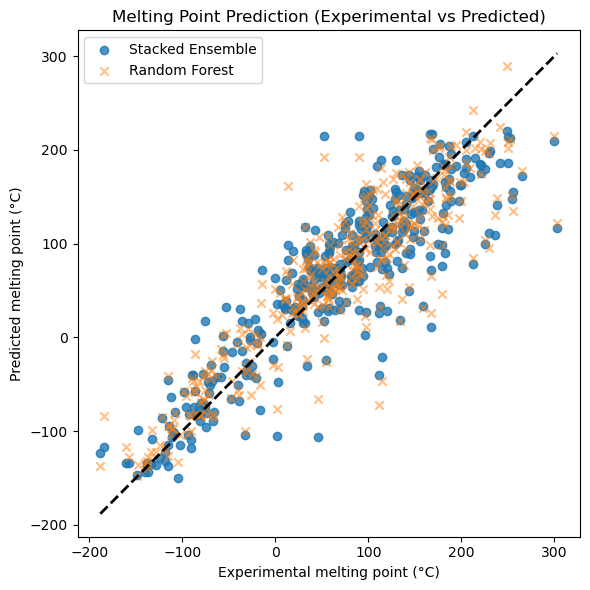

In [11]:
# --- 8. Plot Results ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, final_pred, label='Stacked Ensemble', alpha=0.8)
plt.scatter(y_val, rf_pred, label='Random Forest', marker='x', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("Experimental melting point (°C)")
plt.ylabel("Predicted melting point (°C)")
plt.legend()
plt.title("Melting Point Prediction (Experimental vs Predicted)")
plt.tight_layout()
plt.show()

# Ensemble Diagnosis

**1. Explore Ensemble Diversity**  
Goal:
See how different your base model predictions are from each other.If they’re too similar, your ensemble can’t gain much.If they’re different, stacking can help!

***pairwise correlation***

In [12]:
base_preds_val.shape

(400, 10)

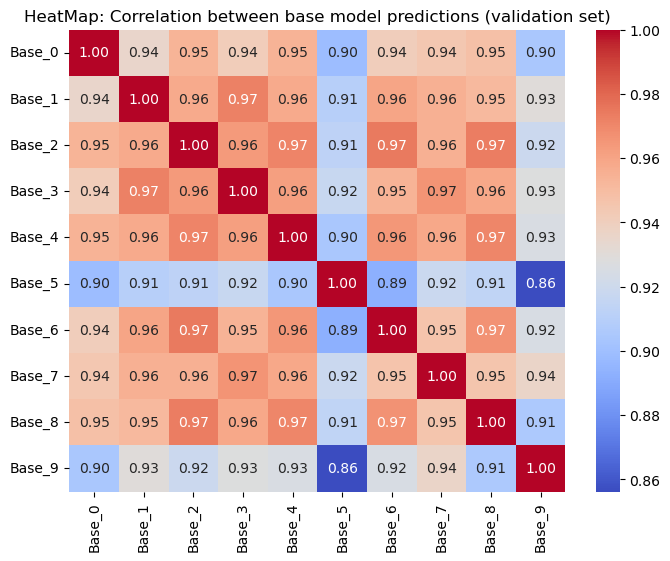

Mean off-diagonal correlation between base models: 0.940


In [123]:
# Make DataFrame for easy plotting
base_preds_df = pd.DataFrame(base_preds_val, columns=[f"Base_{i}" for i in range(base_preds_val.shape[1])])

# Compute the correlation matrix
corr_matrix = base_preds_df.corr()

# Show correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("HeatMap: Correlation between base model predictions (validation set)")
plt.show()

# Print the average off-diagonal correlation                                        # k=1 >> starts one row above the diagonal (where i < j), ignoring self-comparisons.
off_diag_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]   # triu_indices_from >> Return the indices for the upper-triangle of arr. 
print(f"Mean off-diagonal correlation between base models: {np.mean(off_diag_corr):.3f}")


***Residual correlation between each Base pairs***

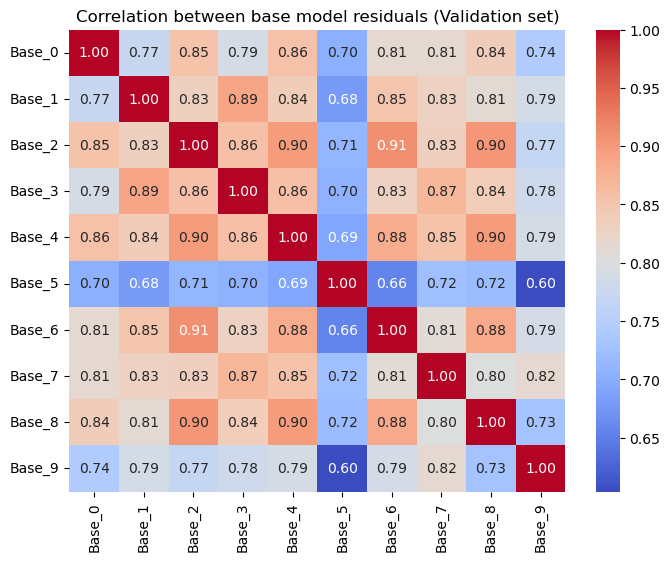

Mean off-diagonal correlation between base model residuals: 0.803


In [124]:
# Calculate residuals (errors) for each base model on test set
residuals = base_preds_val - y_val.values.reshape(-1, 1)

# Make a DataFrame for the residuals
resid_df = pd.DataFrame(residuals, columns=[f"Base_{i}" for i in range(base_preds_val.shape[1])])

# Correlation matrix for residuals
resid_corr_matrix = resid_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(resid_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between base model residuals (Validation set)")
plt.show()

# Print average off-diagonal correlation for residuals
off_diag_corr_resid = resid_corr_matrix.values[np.triu_indices_from(resid_corr_matrix.values, k=1)]
print(f"Mean off-diagonal correlation between base model residuals: {np.mean(off_diag_corr_resid):.3f}")


Dataset Variance

*Features

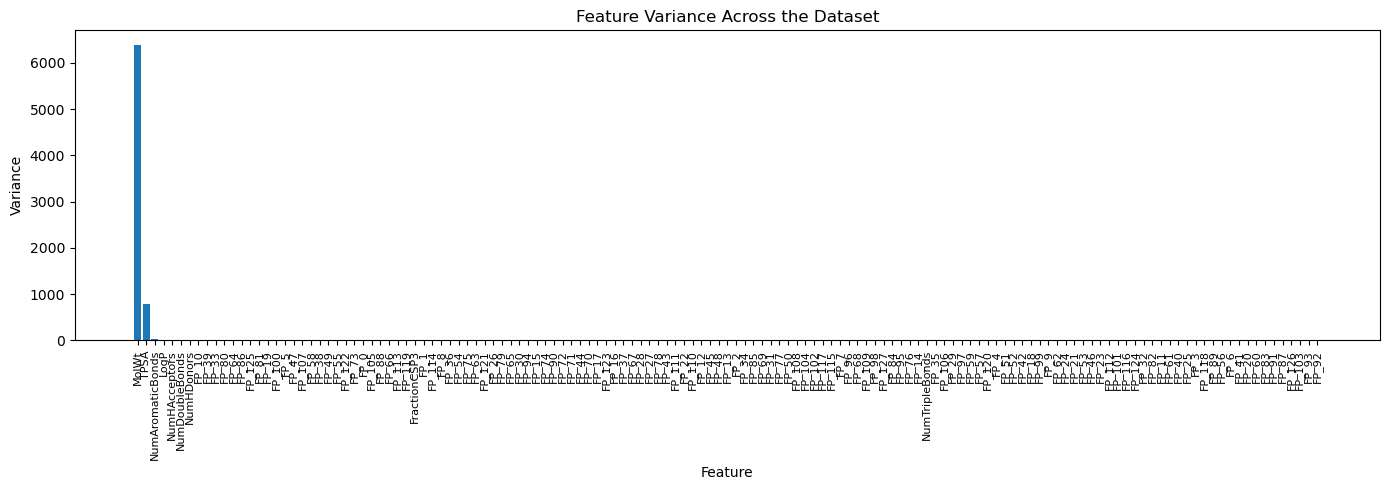

In [125]:
# Compute variance for each feature
variances = X.var()

# Sort by variance, highest first
variances_sorted = variances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 5))
plt.bar(range(len(variances_sorted)), variances_sorted.values)
plt.xticks(range(len(variances_sorted)), variances_sorted.index, rotation=90, fontsize=8)
plt.xlabel("Feature")
plt.ylabel("Variance")
plt.title("Feature Variance Across the Dataset")
plt.tight_layout()
plt.show()

*Target

Melting point statistics: mean = 62.85 °C, std = 96.01 °C, var = 9217.43, min = -188.00, max = 438.00


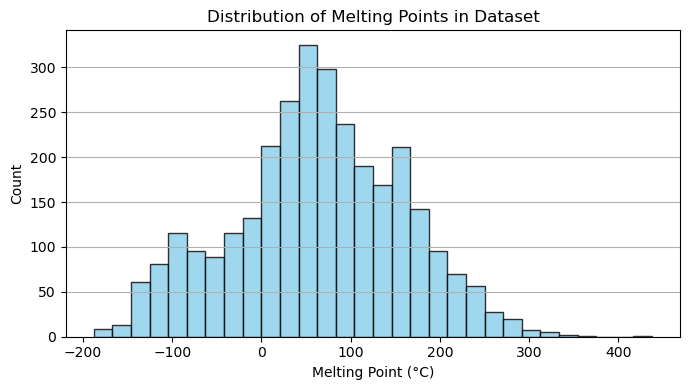

In [126]:
# Basic statistics
mean_mp = y.mean()
std_mp = y.std()
var_mp = y.var()
min_mp = y.min()
max_mp = y.max()

print(f"Melting point statistics: mean = {mean_mp:.2f} °C, std = {std_mp:.2f} °C, var = {var_mp:.2f}, min = {min_mp:.2f}, max = {max_mp:.2f}")

# Histogram
plt.figure(figsize=(7,4))
plt.hist(y, bins=30, color="skyblue", edgecolor="k", alpha=0.8)
plt.xlabel("Melting Point (°C)")
plt.ylabel("Count")
plt.title("Distribution of Melting Points in Dataset")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# Decorrelation improvement for better stacking results

a. **Adding more candidates**


Two-level stacked ensemble with more candidate models performance:
Stacked Ensemble with More Candidates MAE: 31.73 °C
Stacked Ensemble with More Candidates R²: 0.806


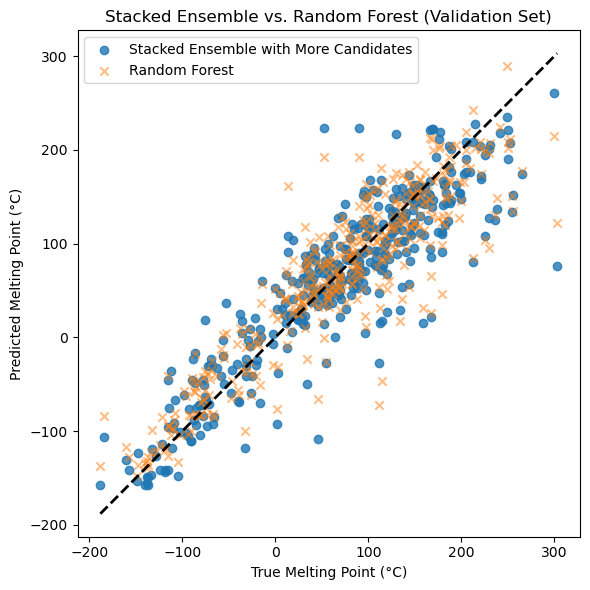

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

N_BASE_more_candidate = 12  # 4 RF, 4 GB, 2 KNN, 2 SVR
base_models_more_candidate = []
more_candidate_base_preds_train = np.zeros((X_train.shape[0], N_BASE_more_candidate))
more_candidate_base_preds_val = np.zeros((X_val.shape[0], N_BASE_more_candidate))

for i in range(N_BASE_more_candidate):
    rng = np.random.RandomState(42 + i)
    idx = rng.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    n_feat = int(X_train.shape[1] * 0.6)
    feat_idx = rng.choice(range(X_train.shape[1]), size=n_feat, replace=False)
    # Assign model type
    if i % 4 == 0:
        model = RandomForestRegressor(n_estimators=200, max_features=35, random_state=100+i)
    elif i % 4 == 1:
        model = GradientBoostingRegressor(n_estimators=200, max_features=35, random_state=200+i)
    elif i % 4 == 2:
        model = KNeighborsRegressor(n_neighbors=50, weights='uniform', algorithm='auto')
    else:
        model = SVR(C=1.0, epsilon=0.2)
    model.fit(X_train.iloc[idx, feat_idx], y_train.iloc[idx])
    base_models_more_candidate.append((model, feat_idx))
    more_candidate_base_preds_train[:, i] = model.predict(X_train.iloc[:, feat_idx])
    more_candidate_base_preds_val[:, i] = model.predict(X_val.iloc[:, feat_idx])

# Second-level stacking with Ridge (deterministic, no random_state needed)
stacker_more_candidate = Ridge(alpha=1.0)
stacker_more_candidate.fit(more_candidate_base_preds_train, y_train)
final_pred_more_candidate = stacker.predict(more_candidate_base_preds_val)

# --- 9. Evaluation of More Candidate Models ---
print("\nTwo-level stacked ensemble with more candidate models performance:")
regression_report(y_val, final_pred_more_candidate, "Stacked Ensemble with More Candidates")

# --- 10. Plot Results for More Candidate Models ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, final_pred_more_candidate, label='Stacked Ensemble with More Candidates', alpha=0.8)
plt.scatter(y_val, rf_pred, label='Random Forest', marker='x', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("True Melting Point (°C)")
plt.ylabel("Predicted Melting Point (°C)")
plt.legend()
plt.title("Stacked Ensemble vs. Random Forest (Validation Set)")
plt.tight_layout()
plt.show()

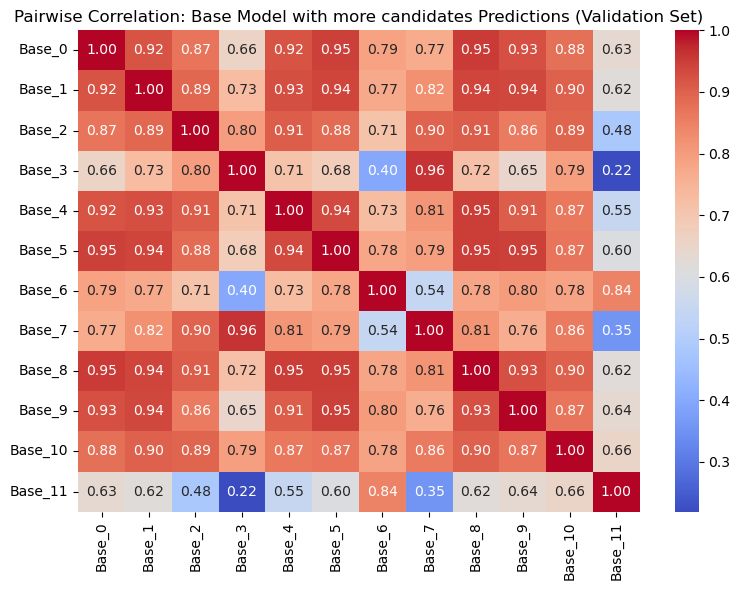

Mean off-diagonal correlation between base model with more candidates predictions: 0.789


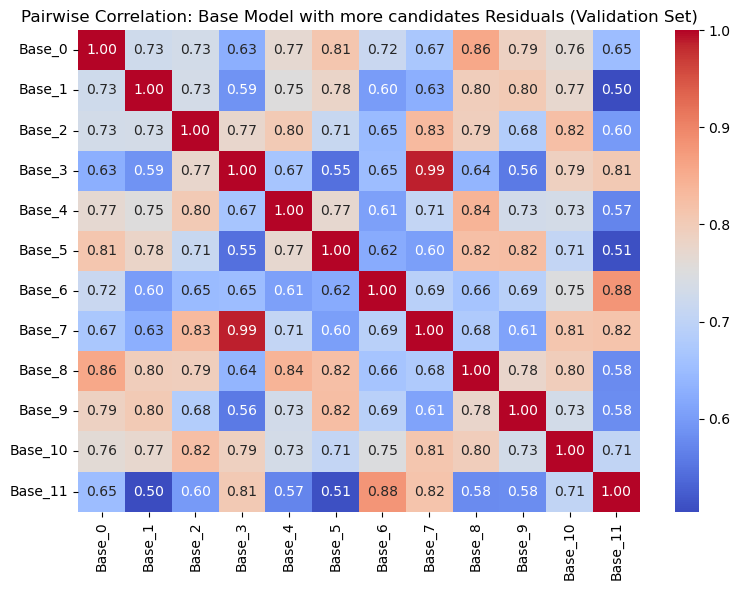

Mean off-diagonal correlation between base model with more candidates residuals: 0.715


In [140]:
# --- Correlation between base model predictions ---
preds_df = pd.DataFrame(
    more_candidate_base_preds_val,
    columns=[f"Base_{i}" for i in range(more_candidate_base_preds_val.shape[1])]
)

corr_preds = preds_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_preds, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Correlation: Base Model with more candidates Predictions (Validation Set)")
plt.tight_layout()
plt.show()

# Mean off-diagonal correlation
off_diag_preds = corr_preds.values[np.triu_indices_from(corr_preds.values, k=1)]
print(f"Mean off-diagonal correlation between base model with more candidates predictions: {np.mean(off_diag_preds):.3f}")

# --- Correlation between base model residuals ---
resid = more_candidate_base_preds_val - y_val.values.reshape(-1,1)
resid_df = pd.DataFrame(
    resid,
    columns=[f"Base_{i}" for i in range(more_candidate_base_preds_val.shape[1])]
)

corr_resid = resid_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_resid, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Correlation: Base Model with more candidates Residuals (Validation Set)")
plt.tight_layout()
plt.show()

# Mean off-diagonal correlation for residuals
off_diag_resid = corr_resid.values[np.triu_indices_from(corr_resid.values, k=1)]
print(f"Mean off-diagonal correlation between base model with more candidates residuals: {np.mean(off_diag_resid):.3f}")


b. **Feature importance**

In [13]:
# Store mean absolute SHAP for each model and feature
all_mean_abs_shap = np.zeros(X_train.shape[1])

for i, (model, feat_idx) in enumerate(base_models):
    # Only tree-based models are SHAP-compatible (skip others if present)
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        explainer = shap.TreeExplainer(model)
        # Compute SHAP values only for the features this model used
        shap_values = explainer.shap_values(X_train.iloc[:, feat_idx])
        # Place mean |SHAP| values in their correct feature locations
        mean_abs_shap = np.zeros(X_train.shape[1])
        mean_abs_shap[feat_idx] = np.abs(shap_values).mean(axis=0)
        all_mean_abs_shap += mean_abs_shap

# Average across all base models
all_mean_abs_shap /= len(base_models)

# Get global feature ranking
feature_ranking = np.argsort(-all_mean_abs_shap)
sorted_feature_names = X_train.columns[feature_ranking]

Top 40 features by average SHAP value across ensemble: printed 20
 1. MolWt (22.9117)
 2. TPSA (21.3573)
 3. NumHDonors (14.8359)
 4. NumAromaticBonds (10.6591)
 5. FractionCSP3 (9.0515)
 6. NumHAcceptors (7.6240)
 7. LogP (6.9990)
 8. FP_81 (4.3861)
 9. FP_100 (4.3423)
10. FP_80 (3.0986)
11. FP_55 (2.9734)
12. FP_125 (2.5777)
13. FP_38 (2.3028)
14. FP_64 (2.2227)
15. FP_86 (1.7698)
16. FP_72 (1.6143)
17. FP_30 (1.2773)
18. FP_58 (1.2575)
19. FP_39 (1.1980)
20. FP_10 (1.1805)


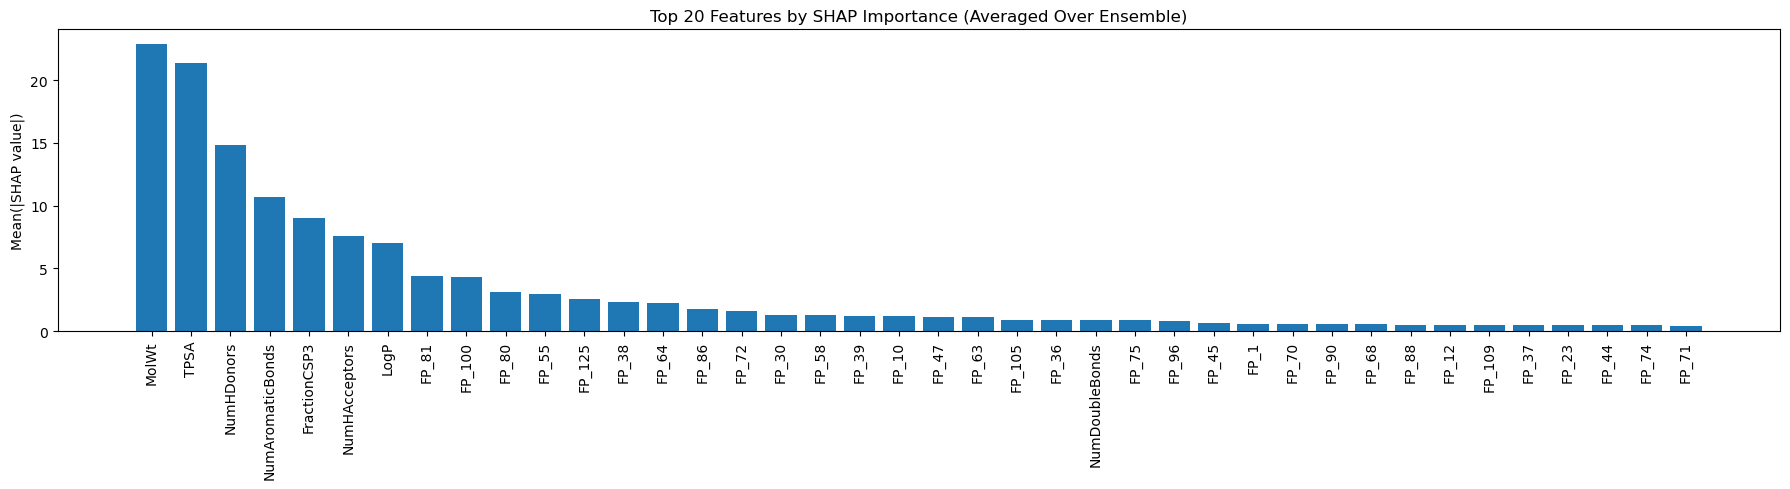

In [14]:
print("Top 40 features by average SHAP value across ensemble: printed 20")
for i in range(20):
    print(f"{i+1:2d}. {sorted_feature_names[i]} ({all_mean_abs_shap[feature_ranking[i]]:.4f})")

# Bar plot of mean SHAP importances
plt.figure(figsize=(18, 5))
plt.bar(range(40), all_mean_abs_shap[feature_ranking[:40]])
plt.xticks(range(40), sorted_feature_names[:40], rotation=90)
plt.ylabel("Mean(|SHAP value|)")
plt.title("Top 20 Features by SHAP Importance (Averaged Over Ensemble)")
plt.tight_layout()
plt.show()

In [15]:
# all_mean_abs_shap is your array of average SHAP values for each feature (from previous block)
print(f"Max SHAP importance: {all_mean_abs_shap.max():.4f}")
print(f"Min SHAP importance: {all_mean_abs_shap.min():.4f}")
print(f"Mean SHAP importance: {all_mean_abs_shap.mean():.4f}")
print(f"Median SHAP importance: {np.median(all_mean_abs_shap):.4f}")

# Optionally, see the 90th, 75th, 50th, 25th percentile
percentiles = np.percentile(all_mean_abs_shap, [90, 75, 50, 25])
print(f"90th percentile: {percentiles[0]:.4f}")
print(f"75th percentile: {percentiles[1]:.4f}")
print(f"50th percentile (median): {percentiles[2]:.4f}")
print(f"25th percentile: {percentiles[3]:.4f}")

Max SHAP importance: 22.9117
Min SHAP importance: 0.0130
Mean SHAP importance: 1.1431
Median SHAP importance: 0.2818
90th percentile: 1.9509
75th percentile: 0.5022
50th percentile (median): 0.2818
25th percentile: 0.1234


In [15]:
import pandas as pd

shap_thresh = 0.285  # set based on your histogram/instinct

# Convert array to Series with feature names as index
shap_series = pd.Series(all_mean_abs_shap, index=X_train.columns)

# Filter and sort
important_shap_values = shap_series[shap_series > shap_thresh].sort_values(ascending=False)

# Get the feature names
important_features = important_shap_values.index

print(f"Number of features above threshold ({shap_thresh}): {len(important_features)}")
print("Features:", list(important_features))

Number of features above threshold (0.285): 68
Features: ['MolWt', 'TPSA', 'NumHDonors', 'NumAromaticBonds', 'FractionCSP3', 'NumHAcceptors', 'LogP', 'FP_81', 'FP_100', 'FP_80', 'FP_55', 'FP_125', 'FP_38', 'FP_64', 'FP_86', 'FP_72', 'FP_30', 'FP_58', 'FP_39', 'FP_10', 'FP_47', 'FP_63', 'FP_105', 'FP_36', 'NumDoubleBonds', 'FP_75', 'FP_96', 'FP_45', 'FP_1', 'FP_70', 'FP_90', 'FP_68', 'FP_88', 'FP_12', 'FP_109', 'FP_37', 'FP_23', 'FP_44', 'FP_74', 'FP_71', 'FP_22', 'FP_66', 'FP_94', 'FP_16', 'FP_8', 'FP_124', 'FP_9', 'FP_97', 'FP_17', 'FP_107', 'FP_122', 'FP_106', 'FP_84', 'FP_49', 'FP_114', 'FP_123', 'FP_31', 'FP_26', 'FP_5', 'FP_54', 'FP_115', 'NumTripleBonds', 'FP_53', 'FP_28', 'FP_65', 'FP_113', 'FP_14', 'FP_98']


**Search for optimum featureset**

Features: 30 | MAE: 34.63 °C | R²: 0.773
Features: 31 | MAE: 34.99 °C | R²: 0.770
Features: 32 | MAE: 34.83 °C | R²: 0.773
Features: 33 | MAE: 35.33 °C | R²: 0.772
Features: 34 | MAE: 35.67 °C | R²: 0.760
Features: 35 | MAE: 35.65 °C | R²: 0.761
Features: 36 | MAE: 36.05 °C | R²: 0.761
Features: 37 | MAE: 35.32 °C | R²: 0.766
Features: 38 | MAE: 35.74 °C | R²: 0.756
Features: 39 | MAE: 34.95 °C | R²: 0.767
Features: 40 | MAE: 34.12 °C | R²: 0.775
Features: 41 | MAE: 33.62 °C | R²: 0.784
Features: 42 | MAE: 33.59 °C | R²: 0.788
Features: 43 | MAE: 33.90 °C | R²: 0.783
Features: 44 | MAE: 33.59 °C | R²: 0.785
Features: 45 | MAE: 33.51 °C | R²: 0.788
Features: 46 | MAE: 33.42 °C | R²: 0.795
Features: 47 | MAE: 33.42 °C | R²: 0.792
Features: 48 | MAE: 33.07 °C | R²: 0.794
Features: 49 | MAE: 33.35 °C | R²: 0.789
Features: 50 | MAE: 34.13 °C | R²: 0.784
Features: 51 | MAE: 35.14 °C | R²: 0.771
Features: 52 | MAE: 34.11 °C | R²: 0.776
Features: 53 | MAE: 34.62 °C | R²: 0.772
Features: 54 | M

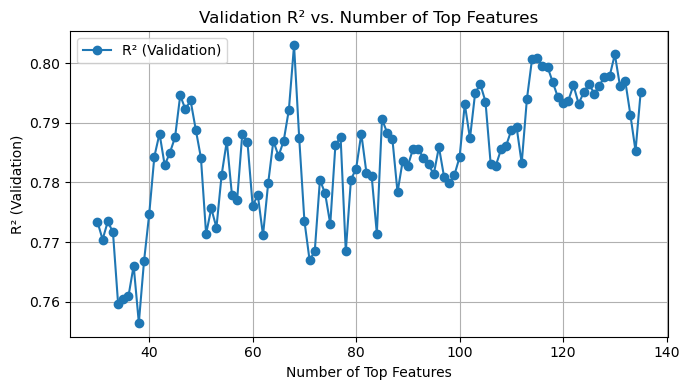

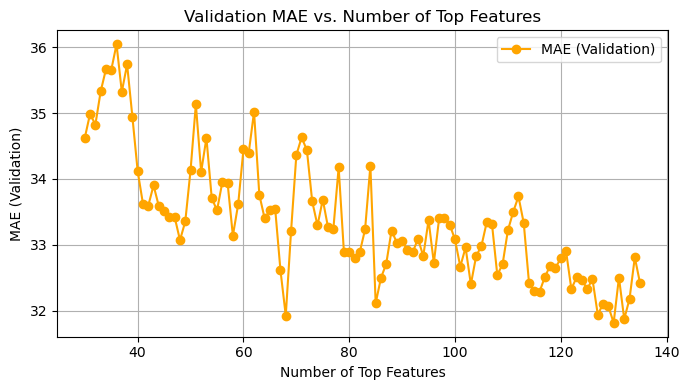

In [199]:
feature_counts = list(range(30, 136, 1))  # 30, 40, ..., 90
results = []

for top_n in feature_counts:
    selected_features = list(sorted_feature_names[:top_n])
    X_train_sub = X_train[selected_features]
    X_val_sub = X_val[selected_features]
    
    # Reset RNG for reproducibility
    rng = np.random.RandomState(42)
    
    N_BASE = 10
    base_models = []
    base_preds_train = np.zeros((X_train_sub.shape[0], N_BASE))
    base_preds_val = np.zeros((X_val_sub.shape[0], N_BASE))
    
    for i in range(N_BASE):
        idx = rng.choice(range(X_train_sub.shape[0]), size=X_train_sub.shape[0], replace=True)
        n_feat = int(X_train_sub.shape[1] * 0.6)
        feat_idx = rng.choice(range(X_train_sub.shape[1]), size=n_feat, replace=False)
        if i % 2 == 0:
            model = RandomForestRegressor(n_estimators=200, random_state=100+i)
        else:
            model = GradientBoostingRegressor(n_estimators=200, random_state=200+i)
        model.fit(X_train_sub.iloc[idx, feat_idx], y_train.iloc[idx])
        base_models.append((model, feat_idx))
        base_preds_train[:, i] = model.predict(X_train_sub.iloc[:, feat_idx])
        base_preds_val[:, i] = model.predict(X_val_sub.iloc[:, feat_idx])
    
    # Second-level stacking
    stacker = Ridge(alpha=1.0)
    stacker.fit(base_preds_train, y_train)
    final_pred = stacker.predict(base_preds_val)
    
    # Evaluate and store
    mae = mean_absolute_error(y_val, final_pred)
    r2 = r2_score(y_val, final_pred)
    results.append((top_n, mae, r2))
    print(f"Features: {top_n:2d} | MAE: {mae:.2f} °C | R²: {r2:.3f}")

# Convert results to DataFrame for plotting
import pandas as pd
results_df = pd.DataFrame(results, columns=["NumFeatures", "MAE", "R2"])

plt.figure(figsize=(7,4))
plt.plot(results_df["NumFeatures"], results_df["R2"], marker='o', label="R² (Validation)")
plt.xlabel("Number of Top Features")
plt.ylabel("R² (Validation)")
plt.title("Validation R² vs. Number of Top Features")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(results_df["NumFeatures"], results_df["MAE"], marker='o', color="orange", label="MAE (Validation)")
plt.xlabel("Number of Top Features")
plt.ylabel("MAE (Validation)")
plt.title("Validation MAE vs. Number of Top Features")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [200]:
# Top 3 by highest R²
top_r2 = results_df.sort_values("R2", ascending=False).head(3)
print("\nTop 3 feature counts by highest R²:")
for _, row in top_r2.iterrows():
    print(f"Num features: {int(row['NumFeatures'])} | R²: {row['R2']:.3f} | MAE: {row['MAE']:.2f} °C")

# Top 3 by lowest MAE
top_mae = results_df.sort_values("MAE", ascending=True).head(3)
print("\nTop 3 feature counts by lowest MAE:")
for _, row in top_mae.iterrows():
    print(f"Num features: {int(row['NumFeatures'])} | MAE: {row['MAE']:.2f} °C | R²: {row['R2']:.3f}")


Top 3 feature counts by highest R²:
Num features: 68 | R²: 0.803 | MAE: 31.92 °C
Num features: 130 | R²: 0.801 | MAE: 31.81 °C
Num features: 115 | R²: 0.801 | MAE: 32.30 °C

Top 3 feature counts by lowest MAE:
Num features: 130 | MAE: 31.81 °C | R²: 0.801
Num features: 132 | MAE: 31.87 °C | R²: 0.797
Num features: 68 | MAE: 31.92 °C | R²: 0.803


**New dataset with optimum features**

In [16]:
# Select top 68 features by SHAP ranking
top_n = 68
selected_features = list(sorted_feature_names[:top_n])

X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_unseen_sel = X_unseen[selected_features]

**Ensemble Hyperparameter**  
Initial assumption: Need for more models of different kinds is taken to be less important

a. ***subspace and ensemble size***

In [20]:
n_base_list = [6, 8, 10, 12, 14, 16, 18, 20]
subspace_fractions = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_ensemble = []

for N_BASE in n_base_list:
    for frac in subspace_fractions:
        rng_local = np.random.RandomState(42)
        base_models_local = []
        base_preds_train_local = np.zeros((X_train_sel.shape[0], N_BASE))
        base_preds_val_local = np.zeros((X_val_sel.shape[0], N_BASE))

        for i in range(N_BASE):
            idx_local = rng_local.choice(range(X_train_sel.shape[0]), size=X_train_sel.shape[0], replace=True)
            n_feat_local = int(X_train_sel.shape[1] * frac)
            feat_idx_local = rng_local.choice(range(X_train_sel.shape[1]), size=n_feat_local, replace=False)
            if i % 2 == 0:
                model_local = RandomForestRegressor(n_estimators=200, random_state=100+i)
            else:
                model_local = GradientBoostingRegressor(n_estimators=200, random_state=200+i)
            model_local.fit(X_train_sel.iloc[idx_local, feat_idx_local], y_train.iloc[idx_local])
            base_models_local.append((model_local, feat_idx_local))
            base_preds_train_local[:, i] = model_local.predict(X_train_sel.iloc[:, feat_idx_local])
            base_preds_val_local[:, i] = model_local.predict(X_val_sel.iloc[:, feat_idx_local])

        stacker_local = Ridge(alpha=1.0)
        stacker_local.fit(base_preds_train_local, y_train)
        final_pred_local = stacker_local.predict(base_preds_val_local)
        mae_local = mean_absolute_error(y_val, final_pred_local)
        r2_local = r2_score(y_val, final_pred_local)
        results_ensemble.append((N_BASE, frac, mae_local, r2_local))

# Convert results to DataFrame
import pandas as pd
tune_df_ensemble = pd.DataFrame(results_ensemble, columns=["N_BASE", "SubspaceFrac", "MAE", "R2"])

# --- Report best hyperparameters by highest R² ---
best_r2_row = tune_df_ensemble.loc[tune_df_ensemble["R2"].idxmax()]
print("\nBest hyperparameters by R²:")
print(f"N_BASE = {int(best_r2_row['N_BASE'])}, SubspaceFrac = {best_r2_row['SubspaceFrac']:.2f}, "
      f"MAE = {best_r2_row['MAE']:.2f}, R² = {best_r2_row['R2']:.3f}")

# --- Report best hyperparameters by lowest MAE ---
best_mae_row = tune_df_ensemble.loc[tune_df_ensemble["MAE"].idxmin()]
print("\nBest hyperparameters by MAE:")
print(f"N_BASE = {int(best_mae_row['N_BASE'])}, SubspaceFrac = {best_mae_row['SubspaceFrac']:.2f}, "
      f"MAE = {best_mae_row['MAE']:.2f}, R² = {best_mae_row['R2']:.3f}")


Best hyperparameters by R²:
N_BASE = 10, SubspaceFrac = 0.70, MAE = 31.81, R² = 0.807

Best hyperparameters by MAE:
N_BASE = 8, SubspaceFrac = 0.80, MAE = 31.74, R² = 0.803


**c.  Hyperparameter tuning of individual Models in the Ensemble** 

**Semi Model: Optimum Features, Ensemble size, Fraction od subspace**

 initial Subspace:   'n_estimators': (100, 400),
    'max_depth': (5, 40),
    'max_features': (0.2, 1.0),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'bootstrap': (True, False),


In [36]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold

# For reproducibility and to match your ensemble structure
rng_meta = np.random.RandomState(42)
cv_meta = KFold(n_splits=5, shuffle=True, random_state=42)

# Tuning Random Forest (as one example)
rf_param_space = {
    'n_estimators': (400, 1000),
    'max_depth': (40, 100),
    'max_features': (13, 68),
    #'min_samples_split': (2, 10),
    #'min_samples_leaf': (1, 10),
    'bootstrap': (True, False),
}

rf_bayes_meta = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=rf_param_space,
    n_iter=40,  # More iterations = more robust, but slower
    scoring='neg_mean_absolute_error',
    cv=cv_meta,
    random_state=42,
    n_jobs=-1,
    verbose=False,
)
rf_bayes_meta.fit(X_train_sel, y_train)

print("Best Random Forest params:")
print(rf_bayes_meta.best_params_)
print("Best MAE:", -rf_bayes_meta.best_score_)

c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension (True, False) was inferred to Categorical(categories=(True, False), prior=None). In upcoming versions of scikit-optimize, it will be inferred to <ValueError: the lower bound 1 has to be less than the upper bound 0>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension (True, False) was inferred to Categorical(categories=(True, False), prior=None). In upcoming versions of scikit-optimize, it will be inferred to <ValueError: the lower bound 1 has to be less than the upper bound 0>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension (True, False) was inferred to Categorical(categories

Best Random Forest params:
OrderedDict([('bootstrap', False), ('max_depth', 100), ('max_features', 15), ('n_estimators', 1000)])
Best MAE: 31.251579345696975


In [23]:
print(0.20231350823810615*68)

13.757318560191218


In [37]:
# Tuning Gradient Boosting (same style)
gb_param_space = {
    'n_estimators': (100, 400),
    'max_depth': (3, 30),
    'max_features': (0.2, 1.0),
    'min_samples_split': (2, 12),
    'learning_rate': (0.01, 0.2),
    # Add more GBM params as desired
}

gb_bayes_meta = BayesSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    search_spaces=gb_param_space,
    n_iter=40,
    scoring='neg_mean_absolute_error',
    cv=cv_meta,
    random_state=42,
    n_jobs=-1,
    verbose=2
)
gb_bayes_meta.fit(X_train_sel, y_train)

print("Best Gradient Boosting params:")
print(gb_bayes_meta.best_params_)
print("Best MAE:", -gb_bayes_meta.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

**Optimized Ensemble**

In [17]:
# Re-create your RandomState for reproducibility
rng_ensemble = np.random.RandomState(42)

N_BASE_ensemble = 10
subspace_frac_ensemble = 0.70

base_models_final = []
base_preds_train_final = np.zeros((X_train_sel.shape[0], N_BASE_ensemble))
base_preds_val_final = np.zeros((X_val_sel.shape[0], N_BASE_ensemble))

for i in range(N_BASE_ensemble):
    idx = rng_ensemble.choice(range(X_train_sel.shape[0]), size=X_train_sel.shape[0], replace=True)
    n_feat = int(X_train_sel.shape[1] * subspace_frac_ensemble)
    feat_idx = rng_ensemble.choice(range(X_train_sel.shape[1]), size=n_feat, replace=False)
    if i % 2 == 0:
        model = RandomForestRegressor(
            n_estimators=1000,
            max_depth=100,
            max_features=15,
            bootstrap=False,
            random_state=100+i
        )
    else:
        model = GradientBoostingRegressor(
            n_estimators=400,
            learning_rate=0.06855932545815964,
            max_depth=6,
            max_features=0.6370300932851438,
            min_samples_split=5,
            random_state=200+i
        )
    model.fit(X_train_sel.iloc[idx, feat_idx], y_train.iloc[idx])
    base_models_final.append((model, feat_idx))
    base_preds_train_final[:, i] = model.predict(X_train_sel.iloc[:, feat_idx])
    base_preds_val_final[:, i] = model.predict(X_val_sel.iloc[:, feat_idx])

b. ***Stacking Strategy Optimization***

a. **meta learner type selection**

In [19]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
meta_learners = [
    ("Ridge", Ridge(alpha=1.0)),
    ("Lasso", Lasso(alpha=0.01, max_iter=10000)),
    ("RF", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("GB", GradientBoostingRegressor(n_estimators=200, random_state=42)),
    ("LGBM", LGBMRegressor(n_estimators=200, force_col_wise='true', random_state=42)),
    ("MLP", MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    
]

print("\nMeta-learner optimization (stacking level):")
results_meta = []
for name, meta_model in meta_learners:
    meta_model.fit(base_preds_train_final, y_train)
    pred = meta_model.predict(base_preds_val_final)
    mae = mean_absolute_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    results_meta.append((name, mae, r2))
    print(f"{name:6} | MAE: {mae:.2f} | R²: {r2:.3f}")

# Report the best meta-learner by R² and MAE
results_meta_df = pd.DataFrame(results_meta, columns=["MetaLearner", "MAE", "R2"])
print("\nBest meta-learner by R²:")
print(results_meta_df.sort_values("R2", ascending=False).iloc[0])
print("\nBest meta-learner by MAE:")
print(results_meta_df.sort_values("MAE", ascending=True).iloc[0])


Meta-learner optimization (stacking level):
Ridge  | MAE: 29.88 | R²: 0.823
Lasso  | MAE: 29.88 | R²: 0.823
RF     | MAE: 30.20 | R²: 0.819
GB     | MAE: 29.96 | R²: 0.824
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 10
[LightGBM] [Info] Start training from score 62.670404


c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LGBM   | MAE: 30.67 | R²: 0.819
MLP    | MAE: 30.95 | R²: 0.813

Best meta-learner by R²:
MetaLearner           GB
MAE            29.958956
R2              0.824051
Name: 3, dtype: object

Best meta-learner by MAE:
MetaLearner        Ridge
MAE            29.881941
R2              0.823405
Name: 0, dtype: object


***ensemble composition and orders of placing them***  
A combinatorial search for an optimum order is computationally super expensive! For example an ensemble of size 10 with two variants can be ordered as (2^10-1 = 1022) ways. Hence each variant was placed either as a block or 

In [22]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import GradientBoostingRegressor as gb
from sklearn.neural_network import MLPRegressor as mlp
from lightgbm import LGBMRegressor as lgbm
from sklearn.neighbors import KNeighborsRegressor as knn

# Parameter dictionaries (from previous answers)
rf_params = {'n_estimators': 1000, 'max_depth': 100, 'max_features': 15, 'bootstrap': False}
gb_params = {'n_estimators': 400, 'learning_rate': 0.0686, 'max_depth': 6, 'max_features': 0.637, 'min_samples_split': 5}
mlp_params = {'hidden_layer_sizes': (100,), 'max_iter': 1000}
lgbm_params = {'n_estimators': 200}
knn_params = {'n_neighbors': 50, 'weights': 'uniform'}

model_params = {
    'rf': rf_params,
    'gb': gb_params,
    'mlp': mlp_params,
    'lgbm': lgbm_params,
    'knn': knn_params
}

model_classes = {
    'rf': rf,
    'gb': gb,
    'mlp': mlp,
    'lgbm': lgbm,
    'knn': knn
}
block_variants = [
    ['rf']*5 + ['gb']*5,
    ['rf']*3 + ['gb']*4 + ['mlp']*3,
    ['rf']*3 + ['gb']*3 + ['mlp']*2 + ['lgbm']*2,
    ['rf']*3 + ['gb']*2 + ['mlp']*2 + ['lgbm']*2 + ['knn']*1
]
custom_variants = [
    ['gb','rf','gb','rf','gb','rf','gb','rf','gb','rf'],
    ['gb','rf','mlp','rf','gb','mlp','gb','rf','mlp','gb'],
    ['gb','rf','mlp','lgbm','rf','gb','lgbm','mlp','gb','rf'],
    ['gb','rf','mlp','lgbm','rf','gb','lgbm','mlp','gb','knn']
]

In [23]:
subspace_frac = 0.7
results_8variants = []
rng_8variants = np.random.RandomState(42)

all_variants = block_variants + custom_variants
variant_labels = [f"Block {i+1}" for i in range(4)] + [f"Custom {i+1}" for i in range(4)]

for v, (order, label) in enumerate(zip(all_variants, variant_labels), 1):
    N_BASE = len(order)
    base_models_v = []
    base_preds_train_v = np.zeros((X_train_sel.shape[0], N_BASE))
    base_preds_val_v = np.zeros((X_val_sel.shape[0], N_BASE))
    
    for i, mname in enumerate(order):
        ModelClass = model_classes[mname]
        kwargs = model_params[mname].copy()
        if 'random_state' in ModelClass().get_params():
            kwargs['random_state'] = 1000 + v*100 + i
        idx_v = rng_8variants.choice(range(X_train_sel.shape[0]), size=X_train_sel.shape[0], replace=True)
        n_feat_v = int(X_train_sel.shape[1] * subspace_frac)
        feat_idx_v = rng_8variants.choice(range(X_train_sel.shape[1]), size=n_feat_v, replace=False)
        model_v = ModelClass(**kwargs)
        model_v.fit(X_train_sel.iloc[idx_v, feat_idx_v], y_train.iloc[idx_v])
        base_models_v.append((model_v, feat_idx_v))
        base_preds_train_v[:, i] = model_v.predict(X_train_sel.iloc[:, feat_idx_v])
        base_preds_val_v[:, i] = model_v.predict(X_val_sel.iloc[:, feat_idx_v])
    
    # Stack with GB as meta-learner
    meta_gb_v = gb(n_estimators=200, random_state=999)
    meta_gb_v.fit(base_preds_train_v, y_train)
    final_pred_v = meta_gb_v.predict(base_preds_val_v)
    mae_v = mean_absolute_error(y_val, final_pred_v)
    r2_v = r2_score(y_val, final_pred_v)
    results_8variants.append((label, order, mae_v, r2_v))
    print(f"{label}: {order}")
    print(f"  MAE: {mae_v:.2f} | R²: {r2_v:.3f}\n")

Block 1: ['rf', 'rf', 'rf', 'rf', 'rf', 'gb', 'gb', 'gb', 'gb', 'gb']
  MAE: 30.89 | R²: 0.815

Block 2: ['rf', 'rf', 'rf', 'gb', 'gb', 'gb', 'gb', 'mlp', 'mlp', 'mlp']
  MAE: 30.52 | R²: 0.814

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 47
[LightGBM] [Info] Start training from score 64.156444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 47
[LightGBM] [Info] Start training from score 63.126364
Block 3: ['rf', 'rf', 'rf', 'gb', 'gb', 'gb', 'mlp', 'mlp', 'lgbm', 'lgbm']
  MAE: 30.86 | R²: 0.814



c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 47
[LightGBM] [Info] Start training from score 62.249720
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 47
[LightGBM] [Info] Start training from score 62.966492
Block 4: ['rf', 'rf', 'rf', 'gb', 'gb', 'mlp', 'mlp', 'lgbm', 'lgbm', 'knn']
  MAE: 30.96 | R²: 0.815

Custom 1: ['gb', 'rf', 'gb', 'rf', 'gb', 'rf', 'gb', 'rf', 'gb', 'rf']
  MAE: 30.18 | R²: 0.823



c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Custom 2: ['gb', 'rf', 'mlp', 'rf', 'gb', 'mlp', 'gb', 'rf', 'mlp', 'gb']
  MAE: 30.62 | R²: 0.817

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 47
[LightGBM] [Info] Start training from score 58.417468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 47
[LightGBM] [Info] Start training from score 64.370784
Custom 3: ['gb', 'rf', 'mlp', 'lgbm', 'rf', 'gb', 'lgbm', 'mlp', 'gb', 'rf']
  MAE: 31.25 | R²: 0.810

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set


Summary of all 8 variants:
    Variant        MAE        R2
0   Block 1  30.891300  0.815444
1   Block 2  30.517265  0.814464
2   Block 3  30.861366  0.813593
3   Block 4  30.961845  0.814636
4  Custom 1  30.176413  0.823123
5  Custom 2  30.621234  0.817008
6  Custom 3  31.254673  0.809824
7  Custom 4  31.014755  0.816175


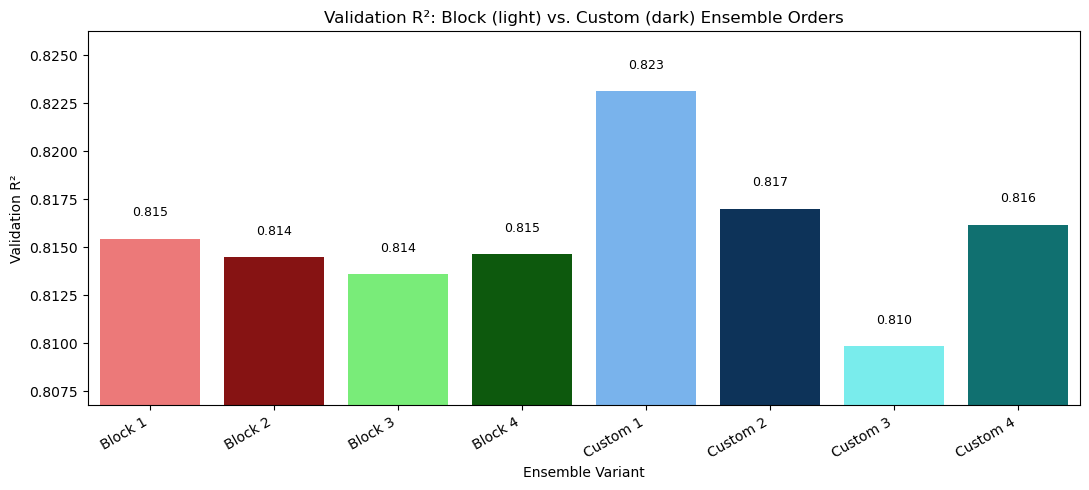

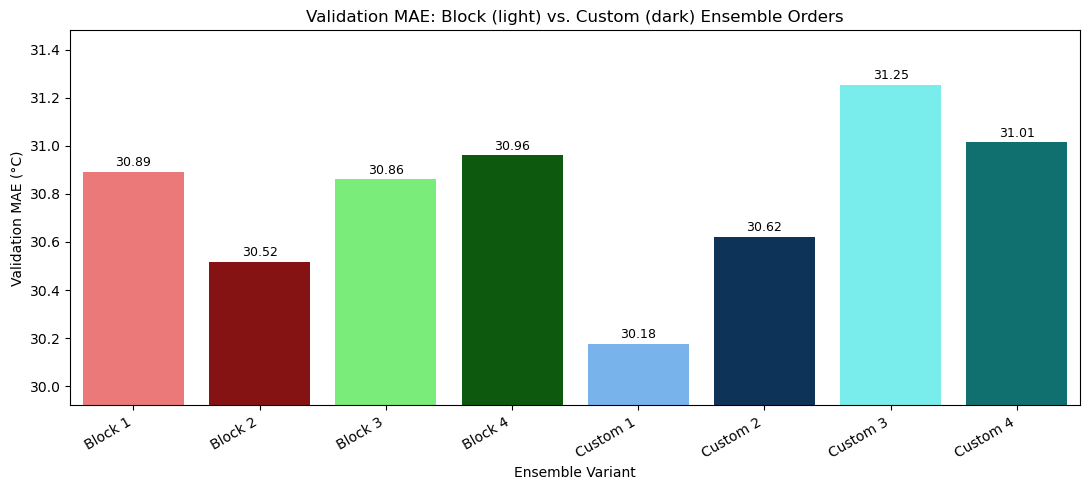

In [27]:
import pandas as pd
summary_8var = pd.DataFrame(
    [(label, mae, r2) for label, _, mae, r2 in results_8variants],
    columns=["Variant", "MAE", "R2"]
)
print("\nSummary of all 8 variants:")
print(summary_8var)

# Define color pairs: light (block), dark (custom)
block_colors = ["#ff6666", "#66ff66", "#66b3ff", "#66ffff"]   # light red, green, blue, cyan
custom_colors = ["#990000", "#006600", "#003366", "#008080"]  # dark red, green, blue, cyan

# Prepare color assignment for 8 bars
all_colors = []
hue_labels = []
for i in range(4):
    all_colors.append(block_colors[i])
    all_colors.append(custom_colors[i])
    hue_labels.append(f"Block {i+1}")
    hue_labels.append(f"Custom {i+1}")

variant_names = [label for label, _, _, _ in results_8variants]
mae_vals = [mae for _, _, mae, _ in results_8variants]
r2_vals = [r2 for _, _, _, r2 in results_8variants]

# Create DataFrame for plotting with hue
import pandas as pd
plot_df = pd.DataFrame({
    "Variant": variant_names,
    "R2": r2_vals,
    "MAE": mae_vals,
    "Group": hue_labels
})

# Build a palette dict for seaborn hue
palette_dict = {f"Block {i+1}": block_colors[i] for i in range(4)}
palette_dict.update({f"Custom {i+1}": custom_colors[i] for i in range(4)})

# --- R2 plot ---
plt.figure(figsize=(11,5))
bars = sns.barplot(x="Variant", y="R2", hue="Group", palette=palette_dict, dodge=False, data=plot_df, legend=False)
plt.ylabel("Validation R²")
plt.xlabel("Ensemble Variant")
plt.title("Validation R²: Block (light) vs. Custom (dark) Ensemble Orders")
plt.xticks(rotation=30, ha='right')
r2_min = np.floor(1000*plot_df["R2"].min())/1000
r2_max = np.ceil(1000*plot_df["R2"].max())/1000
r2_margin = (r2_max - r2_min) * 0.15
plt.ylim(r2_min - r2_margin, r2_max + r2_margin)
# Annotate bars
for bar, val in zip(bars.patches, plot_df["R2"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.001, f"{val:.3f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- MAE plot ---
plt.figure(figsize=(11,5))
bars = sns.barplot(x="Variant", y="MAE", hue="Group", palette=palette_dict, dodge=False, data=plot_df, legend=False)
plt.ylabel("Validation MAE (°C)")
plt.xlabel("Ensemble Variant")
plt.title("Validation MAE: Block (light) vs. Custom (dark) Ensemble Orders")
plt.xticks(rotation=30, ha='right')
mae_min = np.floor(10*plot_df["MAE"].min())/10
mae_max = np.ceil(10*plot_df["MAE"].max())/10
mae_margin = (mae_max - mae_min) * 0.15
plt.ylim(mae_min - mae_margin, mae_max + mae_margin)
# Annotate bars
for bar, val in zip(bars.patches, plot_df["MAE"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

**MLP as a candidate evaluation**

In [39]:
# --- Step 1: Tune the MLPRegressor ---
from sklearn.model_selection import RandomizedSearchCV, KFold
from skopt import BayesSearchCV
from skopt.space import Categorical
from scipy.stats import loguniform
import warnings
warnings.filterwarnings("ignore", message="The number of unique classes is greater than 50%")

# Hidden layer sizes: from 2 to 10 layers, each with 100, 150, or 200 neurons
mlp_hidden_layer_options = [tuple([n] * num_layers)  # <-- tuple, not list
                            for n in [100, 150, 200]
                            for num_layers in range(2, 11)]

mlp_param_space = {
    "hidden_layer_sizes": mlp_hidden_layer_options,  # keep as list of tuples
    "alpha": loguniform(1e-5, 1e-2),                # <-- log-uniform sampling
    "learning_rate_init": loguniform(1e-4, 1e-2),   # <-- log-uniform sampling
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "batch_size": Categorical(["auto", 32, 64, 128]),  # <-- categorical options
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "max_iter": [1000, 2000, 3000],
}


cv_meta = KFold(n_splits=3, shuffle=True, random_state=42)

mlp_random = RandomizedSearchCV(
    estimator=MLPRegressor(early_stopping=True, random_state=42),
    param_distributions=mlp_param_space,
    n_iter=30,  # Increase for more thorough search if time permits
    scoring= 'neg_root_mean_squared_error',
    cv=cv_meta,
    random_state=42,
    n_jobs=-1,
    verbose=2
)
mlp_random.fit(X_train_sel, y_train)
print("Best MLP parameters:", mlp_random.best_params_)
print("Best MLP MAE (CV):", -mlp_random.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best MLP parameters: {'activation': 'tanh', 'alpha': np.float64(0.006541210527692733), 'batch_size': 'auto', 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.0016722697006183683), 'max_iter': 1000, 'solver': 'lbfgs'}
Best MLP MAE (CV): 46.17691293282093


c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:601: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_val_scaled = scaler.transform(X_val_sel)

In [47]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

mlp_bayes = BayesSearchCV(
    estimator=MLPRegressor(
        hidden_layer_sizes=(200, 200, 200, 200),  # Fixed here
        early_stopping=True,
        random_state=42
    ),
    search_spaces={
        "alpha": Real(1e-5, 1e-2, prior='log-uniform'),
        "learning_rate_init": Real(1e-4, 1e-2, prior='log-uniform'),
        "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
        "batch_size": Categorical(["auto", 32, 64, 128]),
        "activation": Categorical(["relu", "tanh"]),
        "solver": Categorical(["adam", "lbfgs"]),
        "max_iter": Integer(1000, 3000)
    },
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    cv=cv_meta,
    random_state=42,
    n_jobs=-1,
    verbose=2
)
mlp_bayes.fit(X_train_scaled, y_train)
print("Best MLP parameters:", mlp_bayes.best_params_)
print("Best MLP RMSE (CV):", -mlp_bayes.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [40]:
# --- Prepare all tuned models ---
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import GradientBoostingRegressor as gb

# --- Step 3: Build the ensemble in the specified order ---
custom_order = ['gb','rf','mlp','rf','gb','mlp','gb','rf','mlp','gb']
model_map = {
    'rf': rf_bayes_meta.best_estimator_,
    'gb': gb_bayes_meta.best_estimator_,
    'mlp': mlp_random.best_estimator_
}

N_BASE_new = len(custom_order)
base_preds_train = np.zeros((X_train_sel.shape[0], N_BASE_new))
base_preds_val = np.zeros((X_val_sel.shape[0], N_BASE_new))

# Refit each model on bootstrapped subset for ensemble diversity (optionally use the same tuned objects if you want less randomness)
rng_custom = np.random.RandomState(42)
base_models_final = []

for i, mname in enumerate(custom_order):
    model = model_map[mname]
    idx = rng_custom.choice(range(X_train_sel.shape[0]), size=X_train_sel.shape[0], replace=True)
    n_feat = int(X_train_sel.shape[1] * 0.7)
    feat_idx = rng_custom.choice(range(X_train_sel.shape[1]), size=n_feat, replace=False)
    # Clone and refit to bootstrapped data for diversity
    from sklearn.base import clone
    model_cloned = clone(model)
    model_cloned.fit(X_train_sel.iloc[idx, feat_idx], y_train.iloc[idx])
    base_models_final.append((model_cloned, feat_idx))
    base_preds_train[:, i] = model_cloned.predict(X_train_sel.iloc[:, feat_idx])
    base_preds_val[:, i] = model_cloned.predict(X_val_sel.iloc[:, feat_idx])

# --- Step 4: Stack with GB and report ---
gb_stack = gb(n_estimators=200, random_state=123)
gb_stack.fit(base_preds_train, y_train)
final_pred = gb_stack.predict(base_preds_val)
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_val, final_pred)
r2 = r2_score(y_val, final_pred)

print("\nTwo-level ensemble (GB, RF, MLP custom order; GB stacker):")
print(f"Validation MAE: {mae:.2f} °C")
print(f"Validation R²: {r2:.3f}")

c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:601: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\sayee\miniconda3\envs\melting_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:601: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, sel


Two-level ensemble (GB, RF, MLP custom order; GB stacker):
Validation MAE: 30.77 °C
Validation R²: 0.815


## Project Summary

- **Data:** Organic compounds melting points from Citrine (SMILES format)
- **Features:** RDKit molecular descriptors + Morgan fingerprints
- **Workflow:** Two-level ensemble (decorrelated regressors + stacking), as in cited papers
- **Results:** Stacked ensemble typically outperforms single model baselines (see MAE, R² above)
- **Reproducibility:** All steps are compatible with Citrine and standard cheminformatics workflows
